In [328]:
from scipy import integrate
import pandas as pd
import numpy as np
import neurolab as nl
import matplotlib.pyplot as plt # version 3.5.0
from factor_analyzer.factor_analyzer import (FactorAnalyzer,
                                             calculate_bartlett_sphericity,
                                             calculate_kmo,) #version 0.4.0
from sklearn.model_selection import train_test_split #version 1.0.2
from sklearn import preprocessing
import neurolab as nl # version 0.3.5
import time

In [329]:
def min_max_manual(v1,vmin,vmax):
    return((v1-vmin)/(vmax-vmin))

Total number of facts is now 4
Factors with ONE_M_M  criterion:

Base correlation: 0.1

['HB', 'NEU', 'Na', 'AST', 'BUN', 'Cr', 'LDH', 'pH', 'PO2', 'PCO2', 'HCO3', 'LAC', 'ONE_M_M']
['HB', 'BUN', 'Cr', 'CRP', 'pH', 'PO2', 'HCO3', 'ONE_M_M']
['Na', 'BUN', 'CRP', 'PCT', 'PO2', 'PCO2', 'HCO3', 'ONE_M_M']
['HB', 'NEU', 'LYM', 'Na', 'AST', 'PCT', 'pH', 'PO2', 'PCO2', 'NLR', 'ONE_M_M']
-----------------

Total number of facts is now 3
Factors with ONE_M_M  criterion:

Base correlation: 0.10500000000000001

['HB', 'NEU', 'Na', 'AST', 'BUN', 'Cr', 'LDH', 'pH', 'PO2', 'PCO2', 'HCO3', 'LAC', 'ONE_M_M']
['Na', 'BUN', 'CRP', 'PCT', 'PO2', 'PCO2', 'HCO3', 'ONE_M_M']
['HB', 'NEU', 'LYM', 'Na', 'AST', 'PCT', 'pH', 'PO2', 'PCO2', 'NLR', 'ONE_M_M']
-----------------

Total number of facts is now 2
Factors with ONE_M_M  criterion:

Base correlation: 0.12100000000000002

['HB', 'AST', 'BUN', 'LDH', 'pH', 'PO2', 'PCO2', 'HCO3', 'LAC', 'ONE_M_M']
['HB', 'NEU', 'LYM', 'Na', 'PCT', 'pH', 'PO2', 'PCO2', 'NLR'

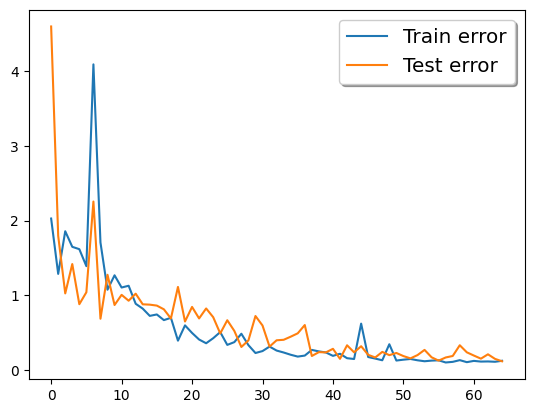

In [330]:
def analyse_facts(df,high_val):
    corrm=df.corr()
    eigen_values = np.linalg.eigvals(corrm)
    # num_of_values=len(eigen_values)
    # eigen_values_cumvar = (eigen_values/num_of_values).cumsum()
    num_factors=sum(eigen_values>1)
    
    chi_square_value,p_value=calculate_bartlett_sphericity(df)
    kmo_var,kmo_total=calculate_kmo(df) # kmo>=0.6 is ok
    
    
    num_factors=sum(eigen_values>1)
    fa = FactorAnalyzer(rotation='varimax', impute='median', method='minres', n_factors=num_factors)
    
    fa.fit(df)
    
    loadings=fa.loadings_
    
    max_loadings=list()
    for i in range(len(loadings)):
        max_loadings.append(max(loadings[i,:]))
    
    colnames=df.columns.tolist()
    rownames=list()
    for i in range (num_factors):
        rownames.append('Factor'+str(i))
    
    factors=pd.DataFrame(columns=colnames,index=rownames)
    
    for i in range (loadings.shape[0]):
        for j in range (loadings.shape[1]):
            #factors.loc['Factor'+str(j)][i]=loadings[i][j]
            factors.iat[j,i] = loadings[i][j]
    #find minimum of factor row maximums
    minima=factors.max(axis=1)
    minima=minima.sort_values()
    
    facts_col=0
    fact_values=list()
    facts_dic={}
    for fact in (factors.index):
        for row in (factors.columns):
            read_factor=factors.loc[fact][row]
            if abs(read_factor)>=high_val:
                fact_values.append(row)
        facts_dic[facts_col]=fact_values
        fact_values=list()
        facts_col+=1
    return facts_dic,num_factors,chi_square_value,p_value,kmo_var,kmo_total

def report(criterion,dictionary):
    values=list()
    facts=list()
    found=False
    for i in range(len(dictionary)):
        if criterion in dictionary[i]:
            for val in dictionary[i]:
                values.append(val)
            found=True
        if found:
            facts.append(dictionary[i])
            found=False
    return list(set(values)),facts

df=pd.read_excel("romjist_data.xlsx")
df1=df.copy()


criterion='ONE_M_M'


df=df.replace(" ","")
df=df.apply(pd.to_numeric)
df=df.dropna(how="any")
# rows with missing values have not been imputed
# instead, they have been dropped

kopya=df.copy()

min_corr=0.1 #default 0.2 #mortality

inc_corr=0.0001
inc_corr=0.001

len_list=float('inf')
prev_len=float('inf')

start_time=time.time()

while len_list>1:
    facts_dic,num_factors,chi_square_value,p_value,kmo_var,kmo_total=analyse_facts(df,min_corr)
    values,facts=report(criterion,facts_dic)
    len_list=len(facts)
    if prev_len>len_list:
        print("Total number of facts is now",len_list)
        print("Factors with", criterion, " criterion:")
        print()
        print("Base correlation:", min_corr)
        print()
        for fact in facts:
            print(fact)
        print("-----------------")
        print()
    if len_list==1:
        print("Reduction to a single factor completed.")
        print("Minimum correlation =",min_corr)
    else:
        min_corr+=inc_corr
        prev_len=len_list
        # print("Number of relevant factors changed")
        # print("Minimum correlation increased. Current value is ",min_corr)
        # print()



z=df[facts[0]]
z=df.copy() # <-- temporary

normalized_df=(z-z.min())/(z.max()-z.min())

dff=df.copy()

#X=dff[values].drop([criterion],axis=1)
X=normalized_df[values].drop([criterion],axis=1)

#value_order=list(dff[values].drop([criterion],axis=1).columns)
value_order=list(normalized_df[values].drop([criterion],axis=1).columns)

# to query the network via net.sim(), value_order is the order of
# columns (fields)

#***
min_max_scaler = preprocessing.MinMaxScaler()
X=min_max_scaler.fit_transform(X) #normalize X
#y=dff[criterion].values
y=normalized_df[criterion].values

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state=1)
y_train=np.array(y_train,ndmin=2).T

nn_in=[[0,1]]*X.shape[1]
# nn_layers=[160,106,70,47,31,20,13,9,1] #works good
nn_layers=[100,80,33,1]
# nn_layers=[100,80,33,11,1]

net=nl.net.newff(nn_in,nn_layers,transf=[nl.trans.LogSig()]*len(nn_layers))
#default error function SSE
net.layers[-1].transf = nl.trans.PureLin()
net.trainf=nl.train.train_gdm
# net.errorf=nl.error.MSE
net.out_minmax=np.array([[0.,1.]])
net.init()

num_epochs=500

min_err=100
test_err=100
val_err=100
min_val=100
min_calc=100
train_err=100
i=0
max_trial=10

#net_error=list()

print()
print("NN training in progress")
print()
total_iter=0
global_train_error=[]
global_test_error=[]
stop_criterion=0.25

while train_err+test_err>=stop_criterion:
    total_iter+=1
    train_error=net.train(X_train,y_train,epochs=num_epochs,goal=1e-6)
    #net_error.append(train_error[-1])
    min_err=min(train_error)
    test_result=net.sim(X_test)
    train_result=net.sim(X_train)
    train_err=np.linalg.norm(train_result-y_train) # L2 norm of train error
    global_train_error.append(train_err)
    test_err=np.linalg.norm(test_result-y_test)
    global_test_error.append(test_err)
    calc=train_err+test_err
    
    if min_calc>calc:
        min_calc=calc
        net_bak=net.copy()
        net.save('best_ann.nl')
        test_err_bak=test_err.copy()
        i=0
        #print("New best. Sleeping...")
        #time.sleep(5)
    
    print()
    print("Current ANN training iteration:",i+1)
    print("Total number of iterations    :",total_iter)
    print()
    print("Train error                   :",train_err)
    print("Test error                    :",test_err)
    print("Train + Test error            :",calc,"(min:",min_calc,")")
    
    mergedX=np.concatenate((X_train, X_test))
    mergedy=np.append(y_train, y_test)
    X_train,X_test,y_train,y_test = train_test_split(mergedX,mergedy,test_size = 0.2)
    y_train=np.array(y_train,ndmin=2).T
    y_test=np.array(y_test,ndmin=2).T
    i+=1
    if i==max_trial:
        print("Resetting to last best neural network!")
        net=net_bak.copy()
        test_err=test_err_bak.copy()
        #print("sleeping...")
        i=0
        #time.sleep(10)
    print("------------------")

elapsed_time = time.time() - start_time
print("elapsed time=",time.strftime("%H:%M:%S",time.gmtime(elapsed_time)))

fig, ax = plt.subplots()
ax.plot(global_train_error,label='Train error')
ax.plot(global_test_error,label='Test error')
legend=ax.legend(loc='upper right', shadow=True,fontsize='x-large')

In [331]:
desc=df.describe()

In [332]:
min_vals=desc.iloc[3,:-1] #exclude target ONE_M_M
max_vals=desc.iloc[7,:-1]
variables=desc.columns
print(variables)

Index(['HB', 'WBC', 'NEU', 'LYM', 'Na', 'K', 'AST', 'BUN', 'Cr', 'D-dimer',
       'LDH', 'CRP', 'PCT', 'pH', 'PO2', 'PCO2', 'HCO3', 'LAC', 'NLR',
       'ONE_M_M'],
      dtype='object')


In [357]:
custom_input=np.array([])
custom_input_real=np.array([])
for i in range(len(value_order)):
    current_var=value_order[i]
    current_min=min_vals[current_var]
    current_max=max_vals[current_var]
    entry=np.inf
    while entry>current_max or entry<current_min:
        entry=float(input(current_var+'değeri (min:'+str(current_min)+'- max:'+str(current_max)+') giriniz = '))
        min_max_norm_value=(entry-current_min)/(current_max-current_min)
        custom_input=np.append(custom_input,min_max_norm_value)
        custom_input_real=np.append(custom_input_real,entry)
custom_input=np.array(custom_input,ndmin=2)
print(net.sim(custom_input))
print(custom_input)

LDHdeğeri (min:108.0- max:3893.0) giriniz =  321
pHdeğeri (min:7.05- max:7.73) giriniz =  7.24
HBdeğeri (min:4.9- max:17.9) giriniz =  13
ASTdeğeri (min:10.0- max:1242.0) giriniz =  24.4
LACdeğeri (min:5.0- max:82.0) giriniz =  29
HCO3değeri (min:12.0- max:33.7) giriniz =  28.1
BUNdeğeri (min:4.0- max:123.0) giriniz =  13


[[0.00055923]]
[[0.05627477 0.27941176 0.62307692 0.01168831 0.31168831 0.74193548
  0.07563025]]


In [355]:
df[df['ONE_M_M']==0][value_order]

LDH    pH    HB    AST   LAC  HCO3   BUN
10   285.0  7.40  13.4   40.0  18.0  23.0  11.0
12   321.0  7.24  13.0   24.4  29.0  28.1  13.0
13   227.0  7.33  10.5   17.4   7.0  20.5  38.0
14   217.0  7.38  11.8   16.9  14.0  22.0  33.0
17   603.0  7.31  12.4   51.7  13.0  24.0  15.0
..     ...   ...   ...    ...   ...   ...   ...
143  186.0  7.41   9.7   29.8  18.0  26.8  21.0
144  440.0  7.32   8.9  109.7   9.0  22.0  37.0
145  337.0  7.36  17.9   39.3  15.0  26.7  16.0
146  188.0  7.41  14.4   24.4   7.0  24.8  15.0
149  476.0  7.44  12.6   73.0  20.0  26.7  32.0

[95 rows x 7 columns]